# 1. Project Overview

***Objective***: Segment retail customers into meaningful groups using transactional data, enabling targeted marketing, retention strategies, and revenue optimization.

***Dataset***: Online Retail Transaction Data (Invoice-level)

***Approach***:

* Rigorous data cleaning

* Customer-level feature engineering (RFM + behavioral)

* Proper scaling and validation

* Unsupervised learning (KMeans)

* Statistical and business interpretation*

# 2. Imports & Configuration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score

import hdbscan

RANDOM_STATE = 53
np.random.seed(RANDOM_STATE)

# 3. Data Loading

In [2]:
data = pd.read_csv('customer_segmentation.csv', encoding='latin-1')
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# 4. Data Cleaning

In [3]:
# Remove cancelled invoices
data = data[~data["InvoiceNo"].astype(str).str.startswith("C")]

# Remove missing customers
data = data.dropna(subset=["CustomerID"])

# Remove invalid quantities and prices
data = data[(data["Quantity"] > 0) & (data["UnitPrice"] > 0)]

# Fix product descriptions (StockCode → mode Description)
desc_map = (
    data.dropna(subset=["Description"])
        .groupby("StockCode")["Description"]
        .agg(lambda x: x.value_counts().index[0])
)

data["Description"] = data["Description"].fillna(
    data["StockCode"].map(desc_map)
)

# Remove non-product codes
noise_codes = ["POST", "D", "M", "DOT", "BANK CHARGES"]
data = data[~data["StockCode"].isin(noise_codes)]

# Monetary value
data["TotalPrice"] = data["Quantity"] * data["UnitPrice"]


# 5. Feature Engineering

### 5.1 RFM Features

In [4]:
snapshot_date = data["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = data.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPrice": "sum"
}).reset_index()

rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]

### 5.2 Behavioral Features

In [5]:
behavior = data.groupby("CustomerID").agg({
    "Quantity": "sum",
    "StockCode": "nunique"
}).reset_index()

behavior.columns = ["CustomerID", "TotalQuantity", "UniqueProducts"]

customer_df = rfm.merge(behavior, on="CustomerID")


# 6. Feature Scaling

In [6]:
features = [
    "Recency",
    "Frequency",
    "Monetary",
    "TotalQuantity",
    "UniqueProducts"
]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_df[features])


# 7. Baseline Segmentation

### 7.1 Model Selection

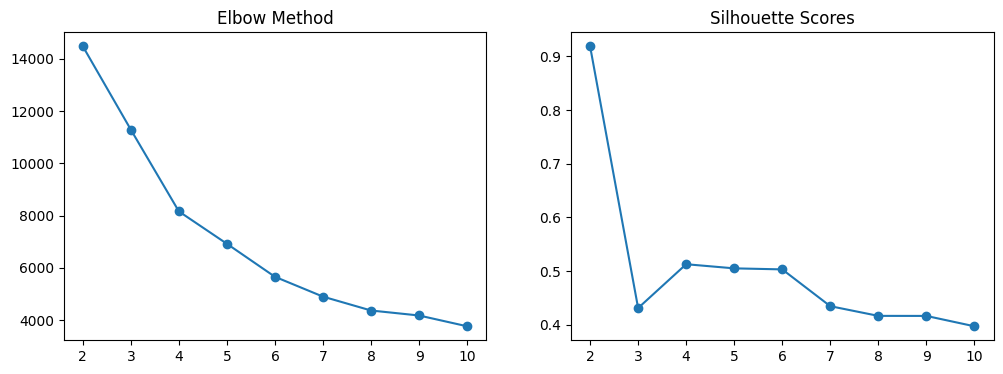

In [7]:
inertia = []
sil_scores = []

for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(2,11), inertia, marker="o")
plt.title("Elbow Method")

plt.subplot(1,2,2)
plt.plot(range(2,11), sil_scores, marker="o")
plt.title("Silhouette Scores")
plt.show()

### 7.2 Final K-Means

In [8]:
kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE)
customer_df["KMeans_Cluster"] = kmeans.fit_predict(X_scaled)

silhouette_score(X_scaled, customer_df["KMeans_Cluster"])

0.512926083590546

# 8 . Cluster Stabillity Testing


### 8.1 Bootstrap Stability

In [9]:
n_bootstraps = 30
ari_scores = []

base_labels = customer_df["KMeans_Cluster"].values

for i in range(n_bootstraps):
    idx = np.random.choice(len(X_scaled), len(X_scaled), replace=True)
    X_sample = X_scaled[idx]

    km = KMeans(n_clusters=4, random_state=i)
    labels = km.fit_predict(X_sample)

    ari = adjusted_rand_score(base_labels[idx], labels)
    ari_scores.append(ari)

print(f"Mean ARI: {np.mean(ari_scores):.3f}")
print(f"Std ARI : {np.std(ari_scores):.3f}")


Mean ARI: 0.737
Std ARI : 0.305


## Interpretation rule (state this in report):

* ARI > 0.75 → highly stable

* 0.5–0.75 → acceptable

* < 0.5 → unreliable

# 9 . Alternative Model I: Gaussian Mixture Model (GMM)

In [10]:
gmm = GaussianMixture(
    n_components=4,
    covariance_type="full",
    random_state=RANDOM_STATE
)

customer_df["GMM_Cluster"] = gmm.fit_predict(X_scaled)

# Soft membership confidence
gmm_probs = gmm.predict_proba(X_scaled)
customer_df["GMM_MaxProb"] = gmm_probs.max(axis=1)

silhouette_score(X_scaled, customer_df["GMM_Cluster"])


0.107471585490664

# 10. Alternative Model II: HDBSCAN (Density-Based)

In [11]:
hdb = hdbscan.HDBSCAN(
    min_cluster_size=30,
    min_samples=15
)

customer_df["HDBSCAN_Cluster"] = hdb.fit_predict(X_scaled)

In [12]:
customer_df["HDBSCAN_Cluster"].value_counts()


HDBSCAN_Cluster
-1    2818
 4     568
 5     414
 2     328
 0      85
 3      82
 1      39
Name: count, dtype: int64

* `-1` → noise / unsegmentable customers

* Indicates niche or anomalous buyers

# 11 . Comparative Analysis

In [13]:
comparison = customer_df.groupby("KMeans_Cluster")[features].mean()
comparison

,Recency,Frequency,Monetary,TotalQuantity,UniqueProducts
KMeans_Cluster,,,,,
0,46.324947,3.295535,1138.510072,701.785259,49.324238
1,16.297052,14.222222,6975.729751,4049.278912,207.811791
2,25.764706,69.882353,111849.459412,64481.647059,592.705882
3,249.925047,1.560721,547.570779,280.012334,24.040797


In [14]:
pd.crosstab(
    customer_df["KMeans_Cluster"],
    customer_df["GMM_Cluster"],
    normalize="index"
)

GMM_Cluster,0,1,2,3
KMeans_Cluster,,,,
0,0.526223,0.170801,0.011339,0.291637
1,0.002268,0.848073,0.149660,0.000000
2,0.000000,0.000000,1.000000,0.000000
3,0.281784,0.000000,0.016129,0.702087


# 12. Visualization

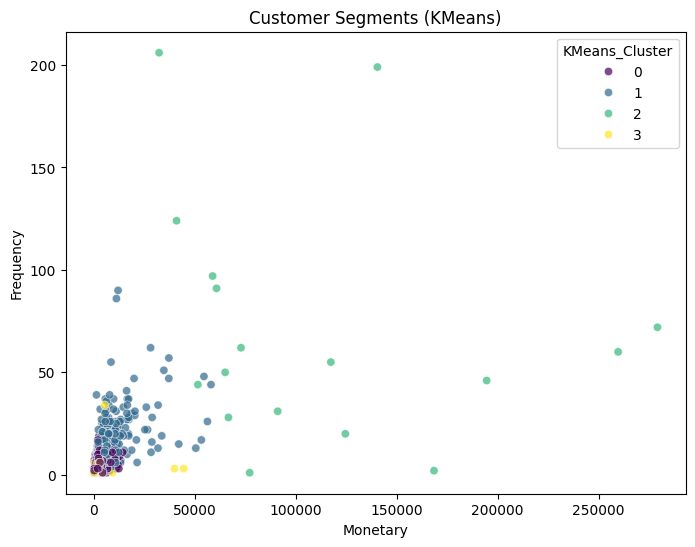

In [15]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=customer_df,
    x="Monetary",
    y="Frequency",
    hue="KMeans_Cluster",
    palette="viridis",
    alpha=0.7
)
plt.title("Customer Segments (KMeans)")
plt.show()


# 13. Business Interpretation


| Cluster | Description                 |
|---------|-----------------------------|
| 0	      | Bulk low-frequency buyers   |
| 1	      | Recent low spenders         |
| 2	      | High-value loyal customers  |
| 3	      |   At-risk customers         |

# 14. Production Pipeline Design

### Inference Function

In [16]:
FINAL_MODEL = kmeans   # baseline, stable, interpretable
FINAL_SCALER = scaler
FINAL_FEATURES = features

In [17]:
def assign_customer_segment(df):
    X = FINAL_SCALER.transform(df[FINAL_FEATURES])
    return FINAL_MODEL.predict(X)

### Artifacts to Persist

* scaler.pkl

* kmeans_model.pkl

* Feature schema JSON

In [19]:
import joblib
import json
from pathlib import Path

ARTIFACT_DIR = Path("../artifacts")
ARTIFACT_DIR.mkdir(exist_ok=True)


In [20]:
joblib.dump(FINAL_SCALER, ARTIFACT_DIR / "scaler.pkl")
joblib.dump(FINAL_MODEL, ARTIFACT_DIR / "kmeans.pkl")
joblib.dump(gmm, ARTIFACT_DIR / "gmm.pkl")


['..\\artifacts\\gmm.pkl']

In [21]:
feature_schema = {
    "features": FINAL_FEATURES,
    "description": {
        "Recency": "Days since last purchase",
        "Frequency": "Number of invoices",
        "Monetary": "Total spend",
        "TotalQuantity": "Total items purchased",
        "UniqueProducts": "Distinct products purchased"
    }
}

with open(ARTIFACT_DIR / "feature_schema.json", "w") as f:
    json.dump(feature_schema, f, indent=4)
